# Locationing Lab: Week 1

### EE16A: Designing Information Devices and Systems I

**Name 1:**

**Login:** ee16a-

**Name 2:**

**Login:** ee16a-

####[Lab Presentation](https://docs.google.com/presentation/d/1ccamolB2sI-D63CRtwl9Nv_pZRCNMlXqW49b8MFqJCQ/edit?usp=sharing)
####[Introduction](#w1)
####[Task 1: Measuring the Similarity of Two Signals](#task1)
####[Task 2: Extracting information](#task2)
####[Task 3: Separating Real Signals](#task3)

<a id='w1'></a>
## Introduction

There are various positioning systems in our life, and we use them everyday. The most commonly used one is the [Global Positioning System (GPS)](http://en.wikipedia.org/wiki/Global_Positioning_System). The navigation systems in cars, Google Map, cell phones, and even rockets and spaceships all use the GPS.

In this lab, we are going to explore the basics of these navigation systems and build our own. At the end of this lab, you will be able to determine your location in a 2D area using just a microphone!

## Basic Principle of Operation
GPS satellites broadcast a variety of measurements including time from a very precise clock, as well as the satellite's position, velocity, etc. GPS receivers make use of the fact that light propagates at a known speed, so the receiver can compute distance from the satellite by measuring how long it takes the GPS signal to propagate from the satellite to the receiver.

<center>
<img src="http://inst.eecs.berkeley.edu/~ee16a/sp15/Labs/location/nb_img/wk1_standard_gps.png" align="center" style="height:250px">
**Source**: [Kathleen Cantner, AGI](http://www.earthmagazine.org/article/precise-fault-how-gps-revolutionized-seismic-research)
</center>

Just like the GPS, we will use speakers as our signal emitters (like the "GPS satellite"), and use microphones (our version of the "GPS chip") to receive the signals. Based on the delay between the times at which we receive each signal we can determine distances.

In [6]:
%pylab inline
import numpy as np
%run support_code/virtual.py
%run support_code/signals.py

Populating the interactive namespace from numpy and matplotlib


<a id='background'></a>
## Extracting Information
The block diagram below shows a high level overview of the full system. We begin by transmitting the signal from the speakers. This signal is then recorded by the microphone and converted to a format we can use for further processing. Next the signals from each speaker are identified and the time differences are used to determine locations.

<center>
<img src="http://inst.eecs.berkeley.edu/~ee16a/images/location_img/wk1_block_diagram.png" align="center" style="height:450px">
</center>

<a id='task1'></a>
##<font color="blue">Task 1: Measuring the Similarity of Two Signals

Just like real GPS, our system will have multiple speakers emitting signals, but only a single microphone receiving them. The signal that we receive from the microphone will therefore be a sum of the individual speaker outputs. In order to determine which signal came from which speaker, we must first separate our raw received signal back into the components that correspond to each speaker. In order to identify the different components in our single recorded microphone signal we will use a tool called **cross-correlation**. 

**[Cross-correlation](http://en.wikipedia.org/wiki/Cross-correlation)** is a measure of similarity between two signals calculated by taking successive products as one function slides past the other. More intuitively this is a measure of the "common area" or "overlap" between two signals with respect to time. For discrete signals, the "common area" at time $t$ is the product of the two signals evaluated at that time. Both a mathematical definition and an animation are shown below where f & g are real valued functions:

$$(f \star g)[n]\ \stackrel{\mathrm{def}}{=} \sum_{m=-\infty}^{\infty} f[m]\ g[m+n]$$

<img src="http://i0.wp.com/www.fromquarkstoquasars.com/wp-content/uploads/2014/03/cross_correlation_animation_auto-tune.gif" border="0" alt="Animation demonstrating cross-correlation.">

**<font color="red">Each of our signals is a sequence of scalar values. Is there a concept we have already covered in this course that could be used to represent this?**

The value of the cross-correlation at each time step is the sum of the products of overlapping samples from each signal. Our mathematical definition above shows a sum from $-\infty$ to $\infty$, however in this lab we know our signals only have a finite number of values define the value at all other times to be 0; because of this we only need to compute the cross-correlation for the times at which the signals overlap (all other values will be 0).

As a simple, concrete example let's define signal $x_1=[1,2,3]$ and $x_2=[3,2,1]$. In order to change the size of these signals we can either append or prepend zeros. To compute the first sample of cross-correlation, we will shift $x_2$ left until the last value of $x_2$ overlaps with the first sample of $x_1$. We now compute the product of the overlapping values: $1\times 1= 1$. To calculate the second value of the cross-correlation we shift $x_2$ to the right and sum the products: $(2\times 1)+(1\times 2) = 2 + 2 = 4$. We continue this process until the last sample of $x_1$ overlaps with the first value of $x_2$.

**<font color="red">Each value of the cross-correlation is a sum of products between individual elements from our sequences of values. Is this an operation we have already used in this class?**

The cell below illustrates an example of cross-correlation, where signal 1 and signal 2 may be referred to as function f and g (from the equation given above), respectively. The output plots graphically show the starting point of cross-correlation, then the shifting of signal 2 with respect to signal 1 and the resulting cross-correlation at each step. The full cross-correlation is displayed at the end.

input signals:[0 1 2 3 3 2 1 0], [1 2 3 1 1]
cross-correlation:[ 0  1  3  8 14 19 20 16 10  4  1  0]


(0, 24)

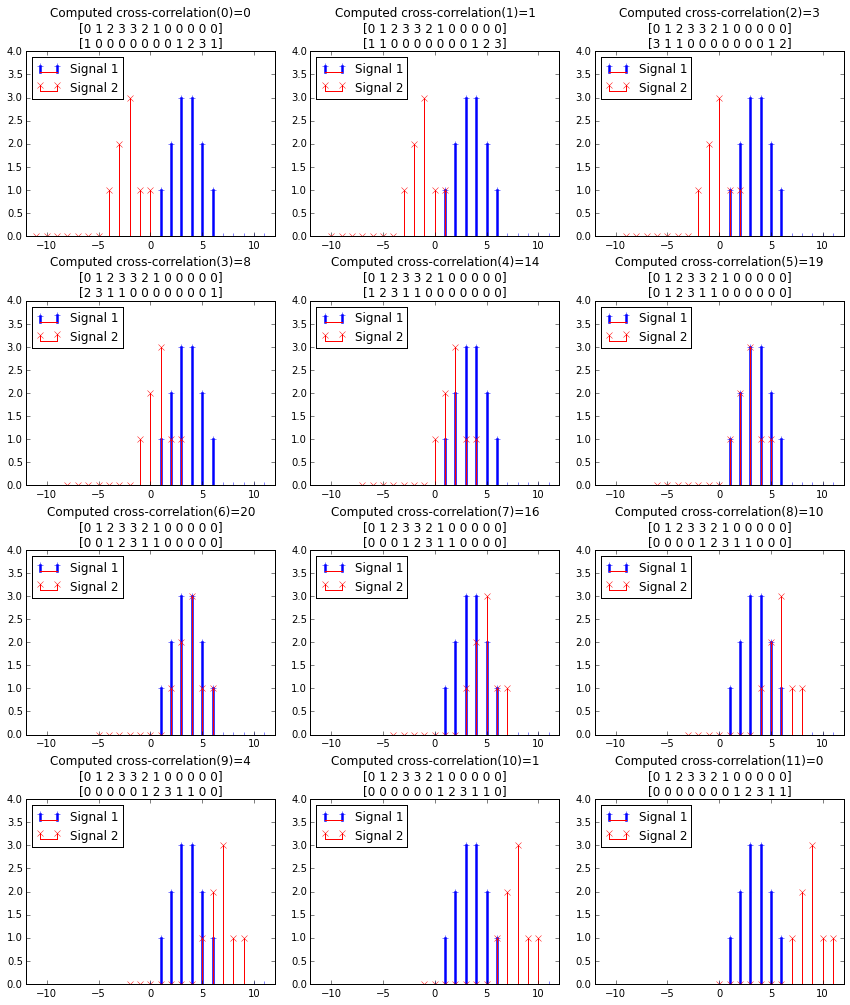

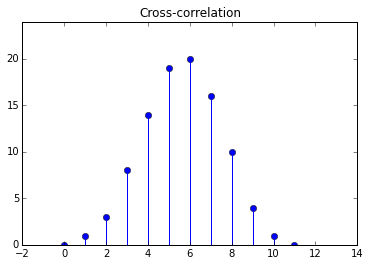

In [7]:
"""Compute the cross_correlation of two given signals    
Args:
signal1 (np.array): input signal 1
signal2 (np.array): input signal 2

Returns:
cross_correlation (np.array): cross-correlation of signal1 and signal2

>>> cross_correlation([0, 1, 2, 3, 3, 2, 1, 0], [0, 2, 3, 0])
[0, 0, 3, 8, 13, 15, 12, 7, 2, 0, 0]
>>> cross_correlation([0, 2, 3, 0], [0, 1, 2, 3, 3, 2, 1, 0])
[0, 0, 2, 7, 12, 15, 13, 8, 3, 0, 0]
"""
# Input signals for which to compute the cross-correlation
signal1 = np.array([0, 1, 2, 3, 3, 2, 1, 0])
signal2 = np.array([1, 2, 3, 1, 1])
corr=np.correlate(signal1, signal2, 'full')
print( 'input signals:'+str(signal1)+', '+str(signal2))
print( 'cross-correlation:'+str(corr)) 

# Pad with zeros to make the signals an appropriate size.
# How should we choose this size?
signal1 = np.lib.pad(signal1, (0, 4), 'constant')
signal2 = np.lib.pad(signal2, (0, 7), 'constant')

# Circularly shift signal2 until the last sample of signal 2 is aligned with the first sample of signal1
# Using a circular shift with the numpy.roll function is a convenient way to simulate shifting signals over time
signal2 = np.roll(signal2, -(5-1))
    
# Plot each operation required to compute the cross-correlation
plt.figure(figsize=(12,14))
signal2_plot = np.roll(signal2, -1)
for i in range(3*4):
    plt.subplot(4,3,i+1)
    markerline, stemlines, baseline = plt.stem(signal1, 'b-', markerfmt='+', label='Signal 1')
    setp(stemlines, 'linewidth','2.5')
    markerline, stemlines, baseline = plt.stem(range(-len(signal2_plot)+1+i,i+1), signal2_plot, 'r-', markerfmt='bx', label='Signal 2')
    setp(markerline, 'color', 'r')
    plt.xlim(-12, 12)
    plt.ylim(0, 4)
    #plt.plot(range(len(lib_result)), lib_result, 'k', label=str_corr, lw=1.5)    
    #plt.plot(range(len(your_result)), your_result, '--r', label=str_your, lw = 3)    
    plt.legend(loc = 'upper left') 
    plt.title('Computed cross-correlation(%d)=%d\n%s\n%s'%(i, np.dot(signal1, signal2), str(signal1), str(signal2)))
    signal2 = np.roll(signal2, 1)
    
# Adjust subplot spacing
plt.tight_layout()
plt.figure()
plt.stem(corr)
plt.title('Cross-correlation')
plt.xlim(-2, 14)
plt.ylim(0, 24)

**<font color="red">Based on example shown above, implement the function below that will compute and return the cross-correlation of two input signals.**

**Things to consider:**
  * Built in `numpy` functions to compute sums of products mentioned above
  * Lengths of the input signals
  * Length of the output
  * Built in `numpy` functions shown above to append or prepend zeros to a signal
  
*Hint:* When computing the cross correlation try defining a numpy array of zeros of the known output length and setting individual values of it. Use operations such as `np.dot` and `np.roll` for array sum of products and array shifting, respectively. An example is shown in the skeleton code below. 

In [8]:
def cross_correlation(signal1, signal2):
    """Compute the cross_correlation of two given signals    
    Args:
    signal1 (np.array): input signal 1
    signal2 (np.array): input signal 2
    
    Returns:
    cross_correlation (np.array): cross-correlation of signal1 and signal2
    
    >>> cross_correlation([0, 1, 2, 3, 3, 2, 1, 0], [0, 2, 3, 0])
    [0, 0, 3, 8, 13, 15, 12, 7, 2, 0, 0]
    >>> cross_correlation([0, 2, 3, 0], [0, 1, 2, 3, 3, 2, 1, 0])
    [0, 0, 2, 7, 12, 15, 13, 8, 3, 0, 0]
    """
    # BEGIN 
    
    # END 
    # This returns the same things as np.correlate(signal1, signal2, 'full')
    # Which is also the same as np.convolve(signal1, signal2[::-1])
    # Don't use those functions for your answer. Build your own correlation code.
    
    signal1, signal2 = np.pad(signal1, (0, len(signal2) - 1), 'constant'), np.roll(np.pad(signal2, (0, len(signal1) - 1), 'constant'), len(signal1))
    
    return np.array([np.dot(signal1, np.roll(signal2, shift)) for shift in range(0, len(signal1))])


In [9]:
def test_correlation_plot(signal1, signal2, lib_result, your_result):
    # Plot the output
    plt.figure(figsize=(16,4))    
    str_corr='Correct Answer (length='+str(len(lib_result))+')'
    str_your='Your Answer (length='+str(len(your_result))+')'
    plt.plot(range(len(lib_result)), lib_result, 'k', label=str_corr, lw=1.5)    
    plt.plot(range(len(your_result)), your_result, '--r', label=str_your, lw = 3)    
    plt.legend()  
    plt.title("Cross correlation of:\n%s\n%s"%(str(signal1), str(signal2)))

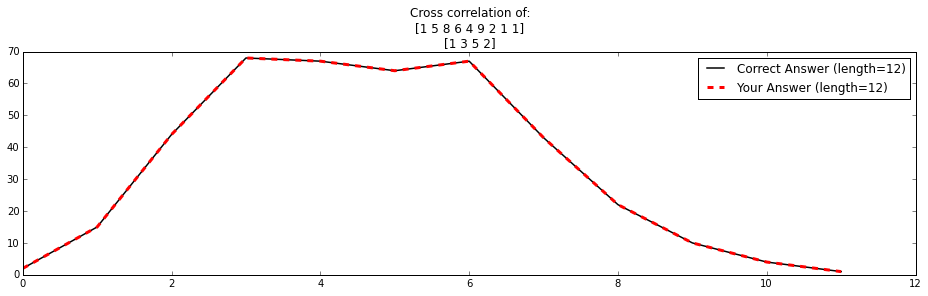

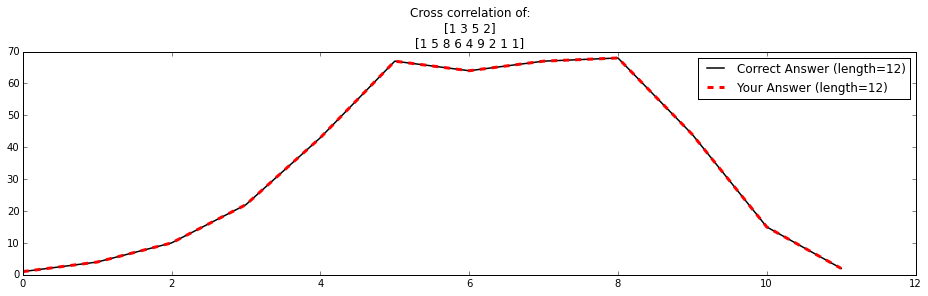

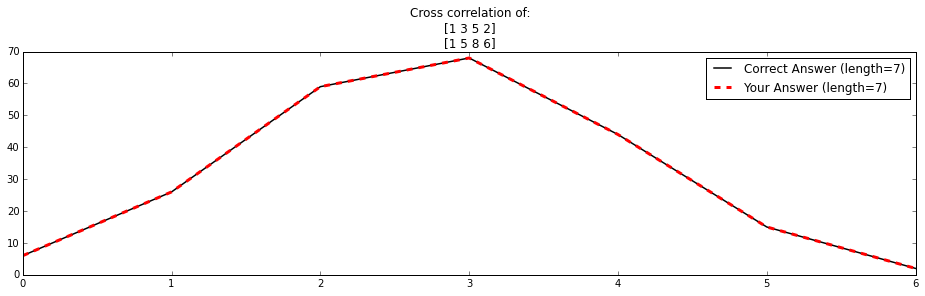

In [10]:
# You can change these signals to get more test cases
# Test 1
signal1 = np.array([1, 5, 8, 6, 4, 9, 2, 1, 1])
signal2 = np.array([1, 3, 5, 2])

# Run the test
lib_result, your_result = test_correlation(cross_correlation, signal1, signal2)
test_correlation_plot(signal1, signal2, lib_result, your_result)

# Test 2
signal1 = np.array([1, 3, 5, 2])
signal2 = np.array([1, 5, 8, 6, 4, 9, 2, 1, 1])

# Run the test
lib_result, your_result = test_correlation(cross_correlation, signal1, signal2)
test_correlation_plot(signal1, signal2, lib_result, your_result)

# Test 3
signal1 = np.array([1, 3, 5, 2])
signal2 = np.array([1, 5, 8, 6])

# Run the test
lib_result, your_result = test_correlation(cross_correlation, signal1, signal2)
test_correlation_plot(signal1, signal2, lib_result, your_result)


<a id='task2'></a>
##<font color="blue">Task 2: Extracting Information
We now have a powerful tool to measure how similar two signals are, and will now explore how to use that in the context of our locationing system.

Our locationing system will be transmitting what we will call a *beacon signal* from each speaker. Figure 3a shows example waveforms of a system composed of two beacons. The beacons are synchronized, meaning each beacon signal is transmitted from one of the speakers at the same time. Figure 3b demonstrates a scenario where the microphone is farther away from beacon 2, picking up its signal with a 3 millisecond delay with respect to beacon 1.

**Figure 3**
<img src="http://inst.eecs.berkeley.edu/~ee16a/images/location_img/Presentation1/Slide2.tiff.png" width=700px></img>

The raw received signal is the black line shown in Figure 4a, which is a superposition of beacon 1 and the delayed beacon 2 signals. Performing a *cross-correlation* of the raw signal with each beacon signal will yield a maximum cross-correlation, which corresponds to the position of that beacon signal. As shown in Figure 4b, looking at the separation of the beacon-raw signal cross-correlation maxima within a period of the signal yields the time delay of 3 milliseconds. From this we can then find the positional difference of the microphone between the speakers of beacon 1 and beacon 2.

**Figure 4**
<img src="http://inst.eecs.berkeley.edu/~ee16a/images/location_img/Presentation1/Slide3.tiff.png" width=700px></img>

In order to successfully identify the beacon signals with our single microphone recording, we would like for the same signal to have a large cross-correlation with itself, but a very small cross-correlation with all of the others. Real GPS deals with this exact same problem and uses pseudorandom binary sequences (signals composed of just 1s and 0s) constructed with exactly this property: they have small mutual cross-correlation, but large cross-correlation with themselves. The theory and implementation of these signals is beyond the scope of this class, but simply understanding the properties of cross correlation explained above is enough to show why we will be using them.

1999


(-500, 1500)

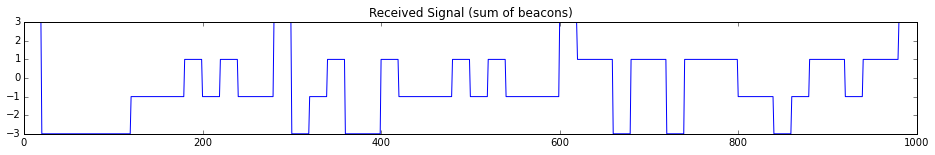

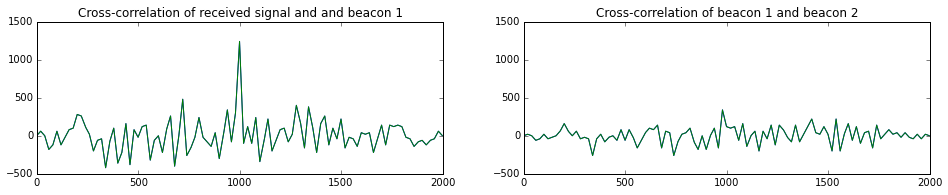

In [11]:
# Model the sending of precomputed beacons
sent_0 = beacon[0][:1000]
sent_1 = beacon[1][:1000]
sent_2 = beacon[2][:1000]

# Model our received signal as the sum of each beacon
received = sent_0 + sent_1 + sent_2

# Plot the received signal
plt.figure(figsize=(16,2))
plt.plot(received)
plt.title('Received Signal (sum of beacons)')

print( len(numpy.convolve(received, sent_1[::-1])))

# Plot the correlation of the received signal and a beacon
plt.figure(figsize=(16,6))
plt.subplot(2,2,1)
plt.plot(np.roll(cross_correlation(received, sent_1), 0))
plt.plot(numpy.convolve(received, sent_1[::-1]))
plt.title('Cross-correlation of received signal and and beacon 1')

# Plot the correlation of two beacons with each other
plt.subplot(2,2,2)
plt.plot(np.roll(cross_correlation(sent_0, sent_1), 0))
plt.plot(numpy.convolve(sent_0, sent_1[::-1]))
plt.title('Cross-correlation of beacon 1 and beacon 2')
plt.ylim(-500, 1500)

We can see that there is a peak around the 1000th sample in the second plot. We can conclude that the first beacon arrives at around $t=1000$ (Warning: the unit here is samples, not seconds!). We can also see that in the third graph, which is the cross-correlation of two signals in a Gold Code, there is no such a peak.

If you are given some beacon signals and a received signals, can you compute when (in sample) does each beacon signal arrive?

**<font color="red">Implement a helper function `identify_peak` which takes in a signal with a single global maximum and returns the index of the peak of the signal.** 

In [12]:
def identify_peak(signal):
    """Returns the index of the peak of the given signal.
    Args:
    signal (np.array): input signal
    
    Returns:
    index (int): index of the peak
    
    >>> identify_peak([1, 2, 5, 7, 12, 4, 1, 0])
    4
    >>> identify_peak([1, 2, 2, 199, 23, 1])
    3
    """
    return np.argmax(signal)

**<font color="red"> Implement a function `arrival_time`, which uses cross-correlation to identify the times at which each beacon arrived in samples.**

In [13]:
def arrival_time(beacons, signal):
    """Returns a list of arrival times (in samples) of each beacon signal.
    Args:
    beacons (list): list in which each element is a numpy array representing one of the beacon signals
    signal (np.array): input signal, for example the values recorded by the microphone
    
    Returns:
    arrival_time [samples] (list): arrival time of the beacons in the order that they appear in the input 
    (e.g. [arrival of beacons[0], arrival of beacons[1]...])
    """
    return [identify_peak(np.correlate(beacon, signal, 'full')) for beacon in beacons]

**<font color="red">Verify the following tests for each of the above functions passes.**

In [14]:
test(cross_correlation, identify_peak, arrival_time, 2)

Test 2 Identify peaks Passed: Your peaks [3,4], Correct peaks [3,4]


**Below code takes couple of seconds**

In [15]:
# If you didn't implement cross-correlation using numpy functions this may take a few minutes to run.
# If you used numpy functions to implement cross-correlation as suggested it should take < 10 sec
# For a length 10,000 signal how total operations would computing the cross-correlation take?
test(cross_correlation, identify_peak, arrival_time, 3)
# If your functions' results are the opposite sign of the correct answer, switch the order of the 
# inputted signals into your cross-correlation function.

Test 3 Arrival time Passed: Your offsets [103,336], Correct offsets [103,336]


<a id='task3'></a>
##<font color="blue">Task 3: Separating Real Signals

Now that we have reviewed the theoretical basis of cross-correlation and shown that it can be used to separate simulated signals, we will test the same functions you wrote with real data.

**<font color="red">Connect your microphone to the appropriate ports on the front of the computer and turn on the speakers.**

First, we need to choose the input device we are using. Run the following code to select audio (input/output) devices:

In [16]:
import pyaudio
%run support_code/rec.py

Now run the code below to define our API for recording signals:

In [17]:
def record_signal():
    """Get the signal from the microphone"""
    return mic.new_data()

Finally, we are ready to record the signal and test our functions! Play **offset_250_540_-321.wav** in the lab folder and use your microphone to record it (by running the cell below - you may want to run it for several times when the wav file is playing to *clear the buffer*.

In [32]:
received_signal = record_signal()

We can now plot the received signal - make sure the signal fills up the whole recording duration!

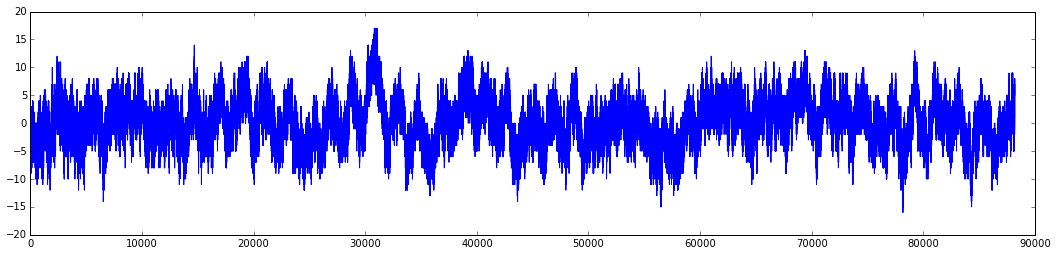

In [33]:
# Plot the received signal
plt.figure(figsize=(18,4))
plt.plot(received_signal)

Now you can test your code! Don't worry if you cannot understand the codes below - you will eventually understand that by the end of Lab 3! This may take a full minute to run.

**Note: the demodulated signal & beacon signals are decimated by 2 to reduce run time.**

In [34]:
import scipy.signal
# Convert the received signals into the format our functions expect
%run support_code/demod.py
demod = demodulate_signal(received_signal)
demod_d = scipy.signal.decimate(demod,2)
beacon_d=[];
for b in beacon[:4]:
    b_d=scipy.signal.decimate(b,2)
    beacon_d.append(b_d)
sig = [cross_correlation(demod_d, b_d) for b_d in beacon_d[:4]]
sig = [average_signal(s) for s in sig]

(7984, 10415)

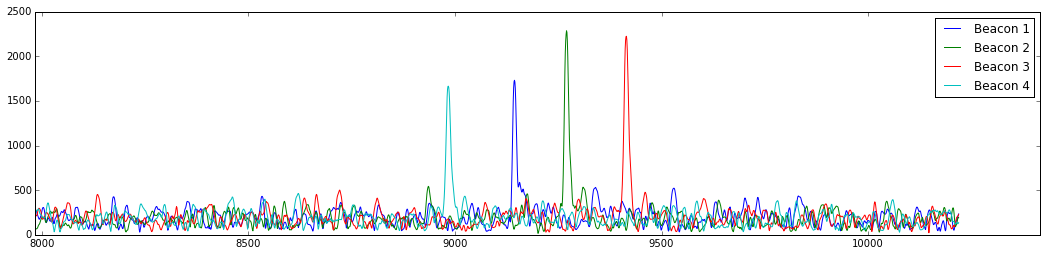

In [35]:
# Plot the cross-correlation with each beacon
plt.figure(figsize=(18,4))
for i in range(len(sig)):
    plt.plot(range(len(sig[i])), sig[i], label="Beacon %d"%(i+1))
plt.legend()

# Scale the x axis to show +/- 1000 samples around the peaks of the cross correlation
peak_times = ([argmax(sig[i]) for i in range(len(sig))])
plt.xlim(max(min(peak_times)-1000, 0), max(peak_times)+1000)

As you can see (if you have the correct implementation), we have several nice peaks after doing the cross-correlation. 
Next week, we will use the functions we wrote this week to determine distances.

<font color="red">PLEASE SAVE THIS NOTEBOOK FOR NEXT WEEK'S LAB!!! We'll be using our `cross_correlation`, `identify_peak`, and `arrival_time` functions we wrote here.
<br/>